Mkk Tutorial

Author: Richard Feder

Date: 10/19/2020

Let me know if any questions come up! I can be contacted via email at rfederst@caltech.edu or richardmfeder@gmail.com

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fftshift as fftshift
from numpy.fft import ifftshift as ifftshift
from numpy.fft import fft2 as fft2
from numpy.fft import ifft2 as ifft2

from mkk_parallel import *
from mkk_diagnostics import *

This notebook shows the different options for using the mkk_parallel.py script. There is parallel in the name 
because there is some multiprocessing functionality available in some of the wrapped functions, but even without 
parallelization the code is fairly fast. 

Because we are obtaining a Monte Carlo estimate from randomly drawn phases, the task is also fairly parallelizable. We pre-compute a number of quantities, 
including the noise realizations. Rather than compute (nsims x number of multipole bins) number of noise realizations, we take advantage of the ring masks being disjoint
in image space. This means that we can draw just (nsims) number of realizations, save them, and apply all masks to the same one set of realizations. This implementation also attempts to 
be efficient in terms of memory allocation, restricting the flow of FFTs to certain regions of memory. The memory usage for 20 x 100 x 1024 x 1024 dtype complex64 arrays that are needed
throughout is 4 Gb, which can lead to a siginficant slowdown in speed because of the lack of available RAM in a machine. For this reason, the user can specify
how many sequential tasks to spread out the memory usage over different iterations. The amount of memory needed using this implementation scales linearly with nsims, dimx and dimy.

The primary class object that contains our functions is called Mkk_bare( ), and this has parameters which can be specified upon initialization. The default for CIBER at the moment is 7" pixel size, 1024x1024 pixels, a corresponding minimum multipole of 180, with 20 log spaced bins.

In [3]:
pixsize=7.
imsize=1024
ell_min=180
logbin=True
nbins=20

Mkk = Mkk_bare(nbins=nbins, ell_min=ell_min, logbin=logbin)

ell max is  185142.85714285716


Once the Mkk_bare class object is instantiated, a number of quantities can be precomputed that speed up performance at run time when computing the Mkk matrices. These can be called explicitly through the function self.precompute_mkk_quantities( ) before running self.get_mkk_sim( ), but if not, the default setting in self.get_mkk_sim( ) is to call self.precompute_mkk_quantities( ):

In [11]:
Mkk.precompute_mkk_quantities(precompute_all=True)

Generating 2D ell map..
minimum/maximum ell is  180.80357142857142 130915.7697739665
Generating multipole bins..
Multipole bin edges: [   180.            250.24100642    347.89200719    483.64914448
    672.38249261    934.7648425    1299.53608308   1806.65120728
   2511.65675757   3491.77508222   4854.36283762   6748.67023346
   9382.18906237  13043.38018557  18133.26991542  25209.37618526
  35046.77593253  48723.00267324  67736.07347125  94168.57331379
 130915.76977397]
No Fourier weights provided, setting to unity..
Computing Fourier ring masks..
Minimum ell_map value is 0.0
self.correspond_bins is  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
self.masked weight sums: [4.00000e+00 4.00000e+00 1.20000e+01 2.40000e+01 4.40000e+01 7.20000e+01
 1.44000e+02 2.88000e+02 5.84000e+02 1.07200e+03 2.12400e+03 4.08000e+03
 7.91200e+03 1.52520e+04 2.94360e+04 5.69880e+04 1.10156e+05 2.12724e+05
 4.06754e+05 2.00900e+05]


You can look at the 2D multipole map to confirm it is as expected:

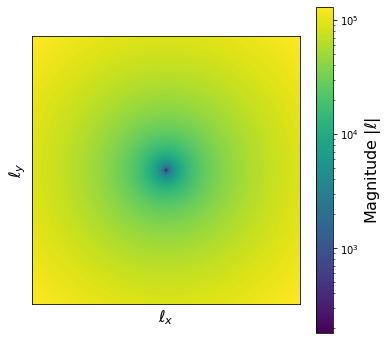

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(Mkk.ell_map, norm=matplotlib.colors.LogNorm())
plt.xlabel('$\\ell_x$', fontsize=16)
plt.ylabel('$\\ell_y$', fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Magnitude $|\\ell|$', fontsize=16)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

The Fourier masks for each multipole bin are also precomputed, one can look at them here:

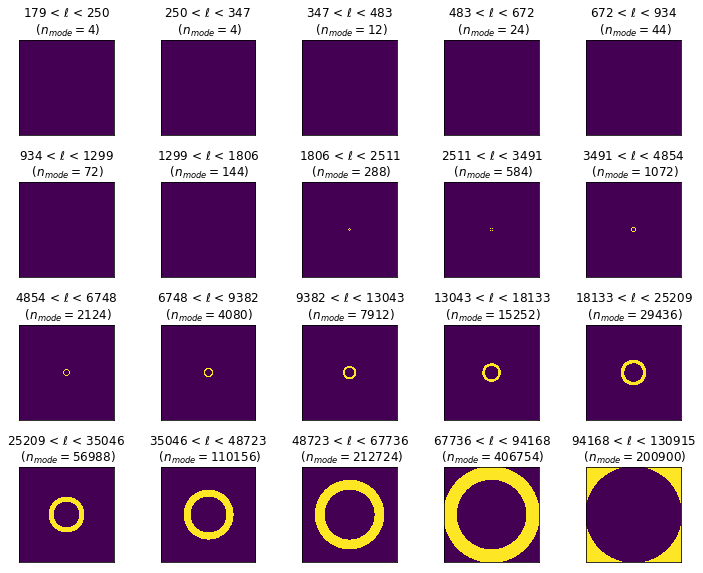

In [13]:
ndim_subplot = np.ceil(np.sqrt(Mkk.nbins))
plt.figure(figsize=(10, 10))
for i in range(Mkk.nbins):
    plt.subplot(ndim_subplot, ndim_subplot, i+1)
    plt.title(str(int(Mkk.binl[i]))+' < $\\ell$ < '+str(int(Mkk.binl[i+1]))+'\n ($n_{mode}=$'+str(int(Mkk.masked_weight_sums[i]))+')')
    plt.imshow(fftshift(Mkk.unshifted_ringmasks[i]).astype(np.int), vmax=1)
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()
plt.show()

From here, one can load in the mask used to compute the mode coupling matrix. I am loading one in from my own directory, but as long as the input mask is a 2D array with the right image dimensions, it should do.

In [4]:
# from ciber_data_helpers import *

# cib = ciber_data(8, 1)
# cib.load_maps()

# mask_inst = cib.load_map_from_stack('mask_inst_clip')
# starmask = cib.load_map_from_stack('strmask')

# mask = mask_inst*starmask

# can also just load mask of all ones (i.e. no masking at all) for a sanity check
mask = np.ones((Mkk.dimx, Mkk.dimy))

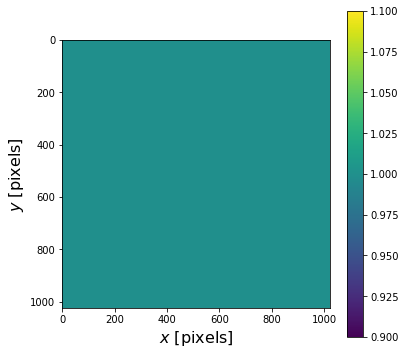

In [15]:
# look at the mask
plt.figure(figsize=(6,6))
plt.imshow(mask)
plt.colorbar()
plt.xlabel('$x$ [pixels]', fontsize=16)
plt.ylabel('$y$ [pixels]', fontsize=16)
plt.show()

But enough playing around, lets actually compute the Mkk matrix! This can be done by calling get_mkk_sim( ) with the mask as input. Because the mean Mkk matrix is an average of many phase realizations, one specifies the number of realizations to average over (denoted below as n_phase_realizations). Because the code is optimized for speed, all of the phase realizations are passed through the mask/Fourier transformed back simultaneously. If these take up too much memory, the performance goes way down, so one can break up the computation. This doesn't significantly slow things down luckily. For my laptop, I have found the limit is around 50 phase realizations at a time for 1024x1024 pixel images, so if I wanted 100 phase realizations total I would set n_phase_realizaations=100 and n_split=2. 

If one wants to see one of the phase realizations for each multipole bin, set show_tone_map = True. 

Number of CPU threads available: 4
Split 1 of 1
band  0


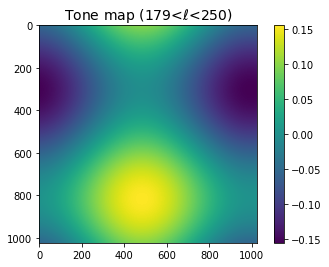

band  1


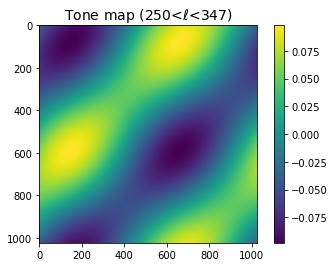

band  2


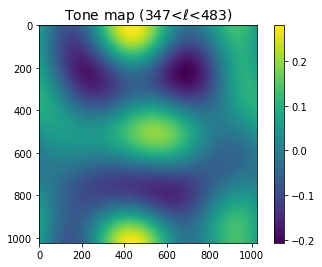

band  3


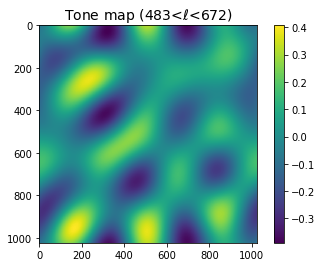

band  4


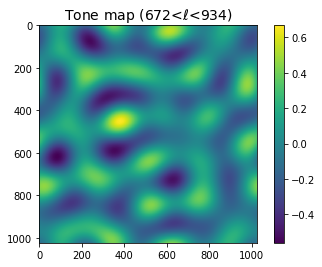

band  5


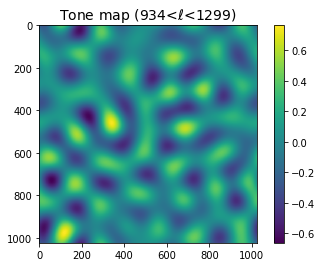

band  6


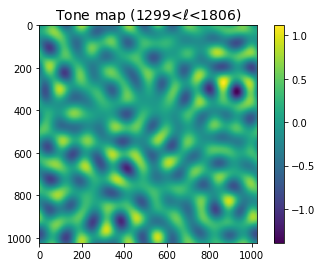

band  7


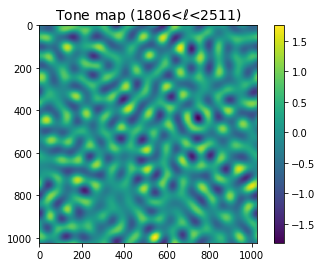

band  8


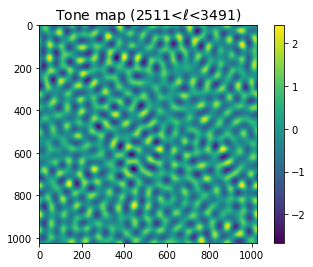

band  9


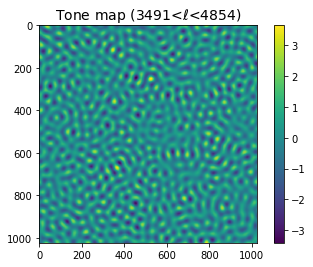

band  10


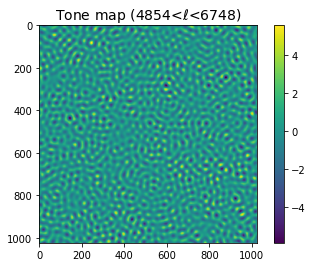

band  11


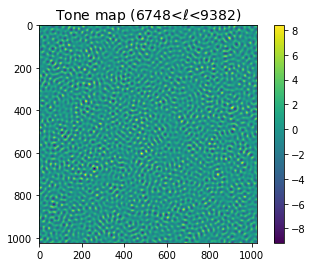

band  12


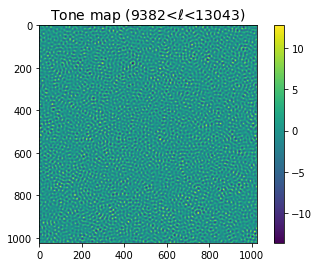

band  13


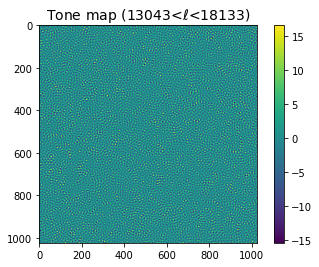

band  14


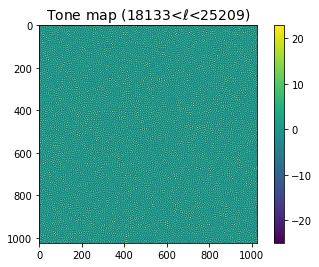

band  15


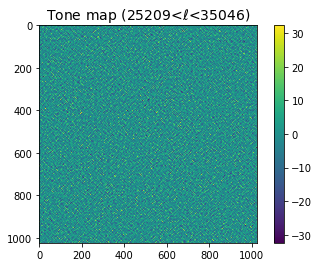

band  16


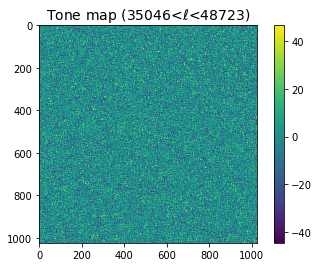

band  17


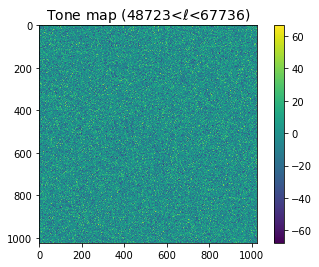

band  18


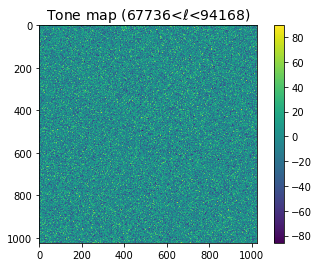

band  19


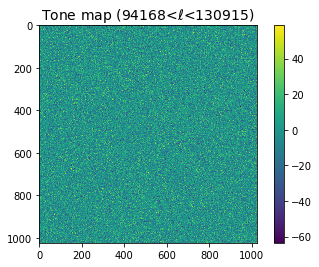

In [8]:
n_phase_realizations = 10
show_tone_map = True
n_split = 1
mkk_matrix = Mkk.get_mkk_sim(mask, n_phase_realizations, show_tone_map=show_tone_map, n_split=n_split,\
                             return_all_Mkks=False, sub_bins=sub_bins)


Once the Mkk matrix is estimated, one can look at it and its inverse with plot_mkk_matrix( ):

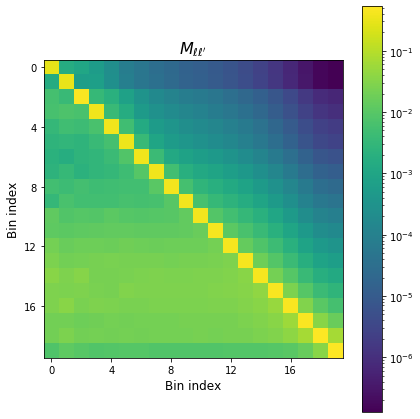

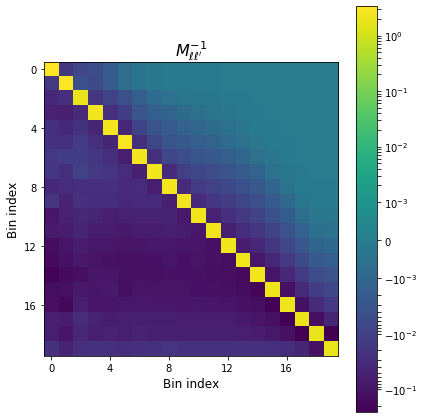

In [9]:
plot_mkk_matrix(mkk_matrix, inverse=False, logscale=True)

inverse_mkk_matrix = compute_inverse_mkk(mkk_matrix)

plot_mkk_matrix(inverse_mkk_matrix, inverse=True, symlogscale=True, symlinthresh=1e-3)

Lastly, to use the Mkk matrix for mode correction, one takes the dot product between 1) the transpose of the inverse mode correction matrix and 2) the masked power spectrum:

In [10]:
cl_masked = np.ones((Mkk.nbins))
rectified_cl = np.dot(inverse_mkk_matrix.transpose(), cl_masked)

In [11]:
print(cl_masked)
print(rectified_cl)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2.02876239 1.94295278 1.26294135 1.64427948 1.63929288 1.77609795
 1.6218761  1.64421772 1.58748163 1.64147941 1.58968394 1.60786297
 1.60545256 1.61845124 1.61252976 1.60632346 1.61218354 1.61246122
 1.60966613 1.61043316]


There is also some more detailed functionality if one wants. For example, if one wants to compute the non-azimuthally averaged M_{kx ky, kx' ky'} matrix for some of the lower multipole bins (too expensive for the the larger multipole bins), one can specify the number of bins that get broken into sub bins with variable n_fine_bins and then run get_mkk_sim( ) with sub_bins=True. These sub bins may be useful when the mask is significantly anisotropic.

ell max is  185142.85714285716
Generating 2D ell map..
minimum/maximum ell is  180.80357142857142 130915.7697739665
Generating multipole bins..
Multipole bin edges: [   180.            254.61812677    360.16883601    509.47507971
    720.67550242   1019.42803577   1442.02698249   2039.81227245
   2885.40655435   4081.53784363   5773.51955614   8166.90407935
  11552.45454574  16341.46853383  23115.74503796  32698.26500318
  46253.17213276  65427.20025466  92549.72871648 130915.76977397]
No Fourier weights provided, setting to unity..
Computing Fourier ring masks..
Minimum ell_map value is 0.0
self.correspond_bins is  [[0, 1], [2, 3], [4, 5, 6, 7, 8, 9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25]]
Number of CPU threads available: 4
Split 1 of 1
band  0
band  1
band  2
band  3
band  4
band  5
band  6
band  7
band  8
band  9
band  10
band  11
band  12
band  13
band  14
band  15
band  16
band  17
band  18
band  19
band  20
band  21
band  2

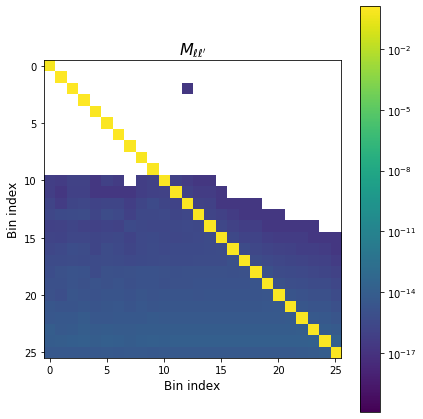

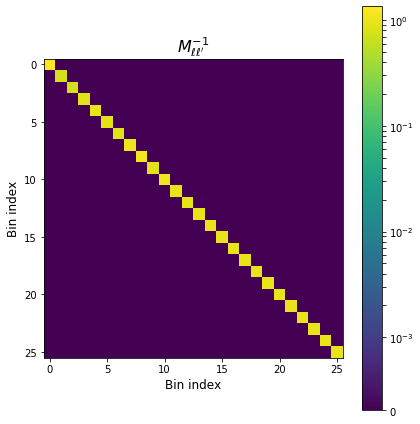

In [9]:
pixsize=7.
imsize=1024
ell_min=180
logbin=True
nbins=19
n_fine_bins=3
n_phase_realizations = 20
show_tone_map=False

M_kxky_kxpkyp = Mkk_bare(nbins=nbins, ell_min=ell_min, logbin=logbin, n_fine_bins=n_fine_bins)
M_kxky_kxpkyp.precompute_mkk_quantities(precompute_all=True, sub_bins=True)
M_kxky_kxpkyp_matrix = M_kxky_kxpkyp.get_mkk_sim(mask, n_phase_realizations, show_tone_map=show_tone_map, n_fine_bins=n_fine_bins, sub_bins=True)

plot_mkk_matrix(M_kxky_kxpkyp_matrix, inverse=False, logscale=True)
inverse_M_kxky_kxpkyp_matrix = compute_inverse_mkk(M_kxky_kxpkyp_matrix)
plot_mkk_matrix(inverse_M_kxky_kxpkyp_matrix, inverse=True, symlogscale=True, symlinthresh=1e-3)

To get rectified power spectra from the hybrid M_{kx ky, kx' ky'}/M_{kk} matrix, modified binning is necessary for both computing the masked power spectrum and then rebinning to azimuthally symmetric bins. The power spectra can be calculated properly with respect to this using the function compute_cl_indiv( ). By setting sub_bins=True and rebin=True, compute_cl_indiv calculates the power spectra and then rebins to azimuthally averaged bins.

In [10]:
# example field with white noise
x = np.random.normal(0, 1, size=(M_kxky_kxpkyp.dimx, M_kxky_kxpkyp.dimy))

cl_true = M_kxky_kxpkyp.compute_cl_indiv(x, sub_bins=True, rebin=True)

cl_masked = M_kxky_kxpkyp.compute_cl_indiv(x*mask, sub_bins=True)

cl_rect = np.dot(inverse_M_kxky_kxpkyp_matrix.transpose(), cl_masked)
# this projects from the sub binned Cl to fully azimuthally binned Cl
cl_rect = np.array([np.mean(cl_rect[M_kxky_kxpkyp.correspond_bins[k]]) for k in range(len(M_kxky_kxpkyp.correspond_bins))])

print((cl_true-cl_rect)/cl_true)



[-3.63618576e-02  1.95816711e-01 -1.61420937e-03 -9.97546590e-02
 -2.54475494e-03  1.73882678e-02 -2.21800962e-02 -3.73008707e-02
 -9.93465939e-03  1.37947043e-04 -7.05938927e-03 -1.58396384e-03
  1.50913367e-03 -2.89790724e-04  2.33814645e-03  2.15794457e-03
 -1.54071475e-04  5.20188997e-04 -2.36066488e-04]


One can also look at the distribution of Mkk matrices from each phase realization by using the Mkk_diag class in mkk_diagnostics.py, which takes in the Mkk_bare object as input. One can look at either distribution of diagonal matrix elements, upper diagonal matrix elements or lower diagonal matrix elements. 

In [12]:
n_phase_realizations = 10
show_tone_map = False
n_split = 1
all_mkk_realizations = Mkk.get_mkk_sim(mask, n_phase_realizations, show_tone_map=show_tone_map, n_split=n_split,\
                             return_all_Mkks=True, sub_bins=sub_bins)


Number of CPU threads available: 4
Split 1 of 1
band  0
band  1
band  2
band  3
band  4
band  5
band  6
band  7
band  8
band  9
band  10
band  11
band  12
band  13
band  14
band  15
band  16
band  17
band  18
band  19


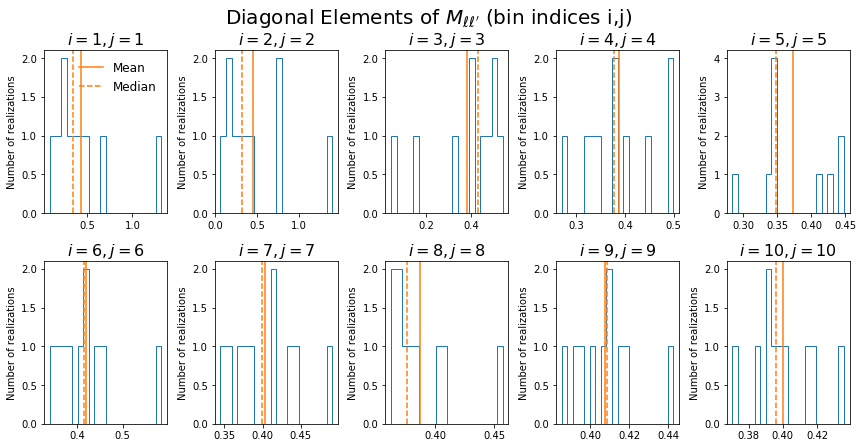

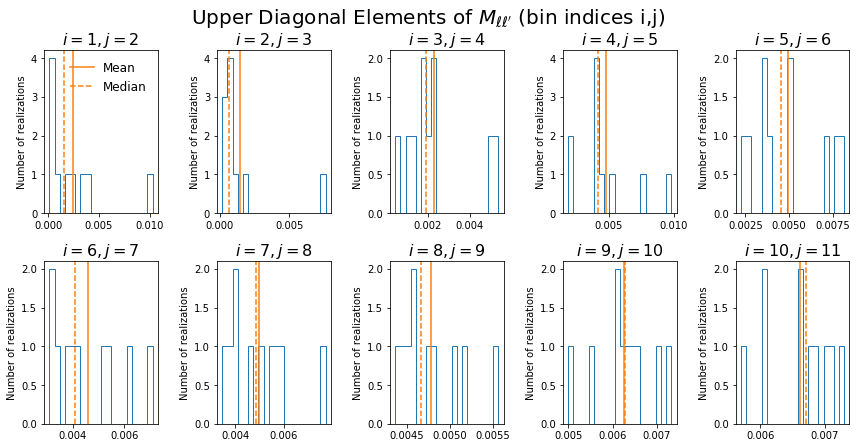

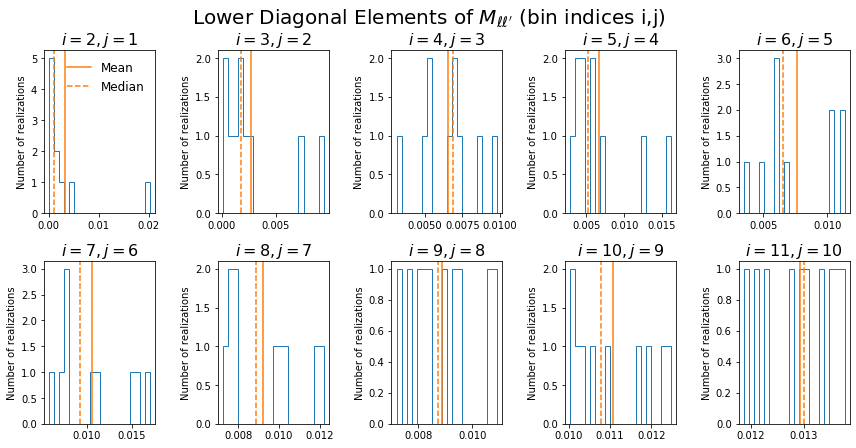

In [13]:
Mkk_diagnostics = Mkk_diag(Mkk)

Mkk_diagnostics.plot_distribution_of_Mkk_elements(elements='diag')
Mkk_diagnostics.plot_distribution_of_Mkk_elements(elements='upper')
Mkk_diagnostics.plot_distribution_of_Mkk_elements(elements='lower')